In [102]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pyvista as pv
import scipy as sc
import math

In [103]:
class quadrupole:
    def __init__(self, data):
        self.data = data
        self.src = pv.PolyData(self.data.T[:3].T)
        self.src['Bx'] = self.data.T[3].T
        self.src['By'] = self.data.T[4].T
        self.src['Bz'] = self.data.T[5].T
        self.src['x'] = self.data.T[0].T
        self.src['y'] = self.data.T[1].T
        self.src['z'] = self.data.T[2].T

    def plot(self):
        self.src.plot(scalars="By")
        
    def interpolate_points(self, xmin, xmax, nx, ymin, ymax, ny, zmin, zmax, nz, field, radius=0.01):
        x = np.linspace(xmin, xmax, nx)
        y = np.linspace(ymin, ymax, ny)
        z = np.linspace(zmin, zmax, nz)
        
        X, Y, Z = np.meshgrid(x, y, z)
        XYZ = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
        dst = pv.PolyData(XYZ).interpolate(self.src, radius=radius)
        
        dst.plot(scalars=field)
        
        dst['x'] = x
        dst['y'] = y
        dst['z'] = z
        
        return dst
        
    def plot_xprofile(self, ypos, zpos, field, radius=0.01, ax=None, color=None):
        assert ypos in self.src['y'] and zpos in self.src['z'], "These values are not present in the data"
        mask = (self.src['y'] == ypos) & (self.src['z'] == zpos)
        
        x = self.src['x'][mask]
        fieldvals = self.src[field][mask]
        
        if ax is None:
            fig, ax = plt.subplots()
            
        ax.plot(x, fieldvals, label=f"y={ypos}, z={zpos}", color=color)
        ax.set_xlabel('x')
        ax.set_ylabel(field)
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
        
    def plot_zprofile(self, xpos, ypos, field, radius=0.01, ax=None, color=None):
        assert xpos in self.src['x'] and ypos in self.src['y'], "These values are not present in the data"
        mask = (self.src['x'] == xpos) & (self.src['y'] == ypos)
        
        z = self.src['z'][mask]
        fieldvals = self.src[field][mask]

        if ax is None:
            fig, ax = plt.subplots()
            
        ax.plot(z, fieldvals, label=f"x={xpos}, y={ypos}", color=color)
        ax.set_xlabel('z')
        ax.set_ylabel(field)
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
        
    def deriv_xprofile(self, ypos, zpos, field, order):
        assert ypos in self.src['y'] and zpos in self.src['z'], "These values are not present in the data"
        mask = (self.src['y'] == ypos) & (self.src['z'] == zpos)
        
        x = self.src['x'][mask]
        fieldvals = self.src[field][mask]
        
        x0ind = int(np.where(x == 0)[0][0])
        h = 2 * (sorted(x)[1] - sorted(x)[0])  # step size
        
        coeffs = np.zeros(order+1)
        # Central finite difference
        for n in range(order+1):
            for i in range(n+1):
                index = int(2*(n/2-i)+x0ind)  # Each step is h/2
                coeffs[n] += 1/h**n * (-1)**i * math.factorial(n)/math.factorial(n-i)/math.factorial(i) * fieldvals[index]

        return coeffs
    
    def fit_xprofile(self, ypos, zpos, field, order, ax=None, xmax=None, returndata=False):
        assert ypos in self.src['y'] and zpos in self.src['z'], "These values are not present in the data"
        if xmax is None:
            xmax = self.src['x'].max()
        mask = (self.src['y'] == ypos) & (self.src['z'] == zpos) & (abs(self.src['x']) < xmax)
        
        x = self.src['x'][mask]
        fieldvals = self.src[field][mask]

        params = np.polyfit(x, fieldvals, order)
        coeffs = [params[order-i] * math.factorial(i) for i in range(order+1)]
        
        if ax:
            ax.scatter(x, fieldvals, label="data")
            xx = np.linspace(x.min(), x.max(), 100)
            ax.plot(xx, np.polyval(params, xx), label="fit", color="black")
            ax.legend()
        
        if returndata:
            return coeffs, x, fieldvals
        return coeffs

In [104]:
data_quad=np.loadtxt("Bfield.txt",skiprows=1)
quad = quadrupole(data_quad)

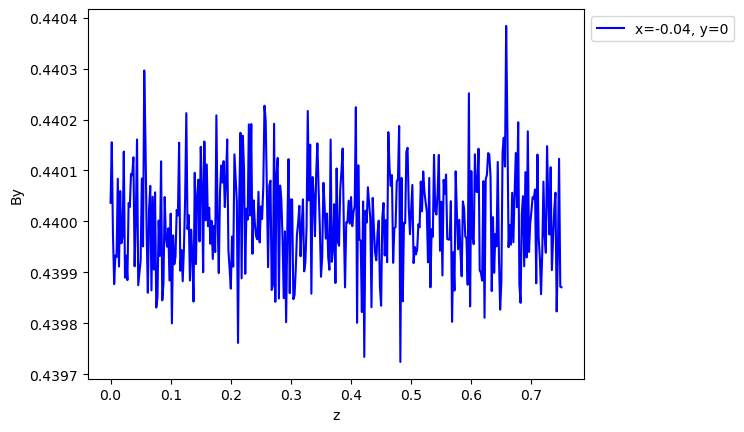

In [105]:
quad.plot_zprofile(-0.04, 0, "By", ax=None, color="blue")

In [106]:
coeffsderiv = quad.deriv_xprofile(0, 0, "By", 5)
coeffsderiv

array([ 7.83416906e-05, -1.00324424e+01,  4.31627927e+01,  6.24715787e+03,
        1.57778137e+06, -1.34924383e+09])

[np.float64(9.422313431478024e-06),
 np.float64(-10.002399005885179),
 np.float64(49.843644389394704),
 np.float64(64.04824142826455)]

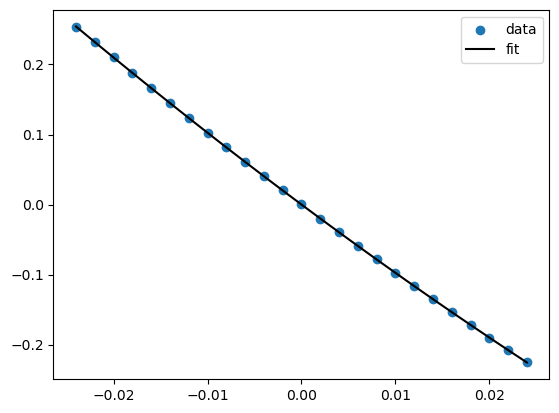

In [107]:
fig, ax = plt.subplots()
coeffs, x, fieldvals = quad.fit_xprofile(0, 0, "By",3, ax=ax, xmax=0.025, returndata=True)
coeffs

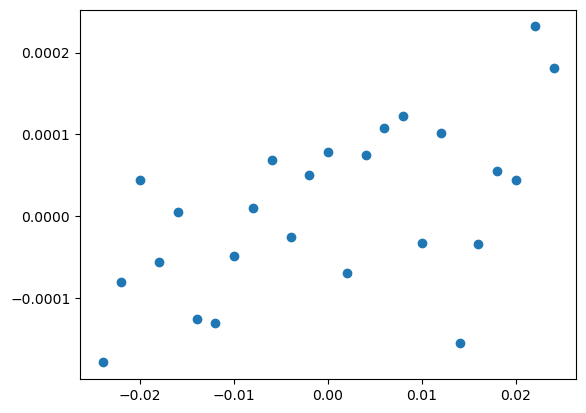

In [108]:
fig, ax = plt.subplots()
ax.scatter(x, fieldvals - coeffs[1]*x - coeffs[2]*x**2/2, label="data")

In [111]:
b3s = []
for ii in np.arange(2,20):
    coeffs0 = np.array(quad.fit_xprofile(0, 0, "By", ii, xmax=0.025))
    b3s.append([ii,coeffs0[2]])
b3s=np.array(b3s)

/tmp/silke/ipykernel_112421/4256538956.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


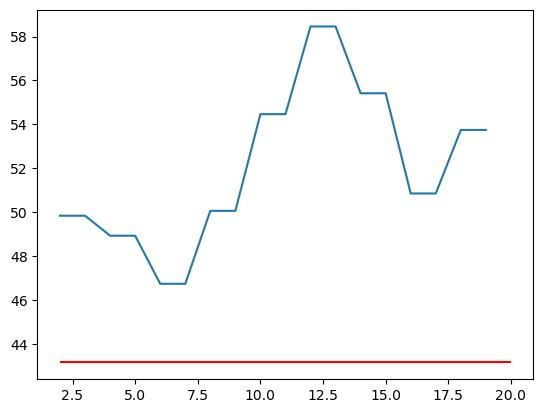

In [113]:
fig,ax = plt.subplots()
ax.plot(b3s[:,0], b3s[:,1])
ax.hlines(coeffsderiv[2],2,20,color="red")
fig.show()